# Circuit optimization using ZX-calculus

Circuit optimisation consists in finding an equivalent quantum circuit (i.e. one that implements the same unitary evolution) and satisfies any of the following:

- has less number of gates of a relevant kind (some gates are more costly than others, for instance, T-reduction or CNOT-reduction),
- has a shorter sequence of consecutive gates (known as depth-reduction),
- uses less qubits...

In this lab session we will be working with PyZX, a library in Python that allows us to manage ZX-diagrams and use the ZX-calculus to optimise circuits. PyZX's documentation can be found at: https://pyzx.readthedocs.io/en/latest/index.html.

[*This Jupyter notebook is a modified version of the one available at https://github.com/Quantomatic/pyzx, created by Aleks Kissinger and John van de Wetering. Changes are due to Pablo Andrés-Martínez and Robert I. Booth.*]


In [1]:
import random
import pyzx as zx

## Clifford circuits

We will first consider Clifford circuits: circuits whose phases are all multiples of $\pi/2$. Clifford circuits are easy to manage because the axioms of the original ZX-calculus are enough to prove any equivalence of Clifford circuits (mathematically, we say the ZX-calculus is complete for Clifford circuits).

In order to use PyZX, we start by importing the library and configuring matplotlib to display the figures in a nice way.

Then we can create a random Clifford circuit and visualise it.

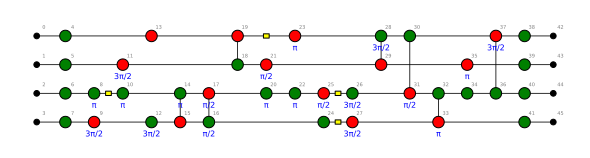

In [2]:
qubit_amount = 4
depth = 15
random.seed(1337)
circ = zx.generate.cliffords(qubit_amount, depth)
zx.draw_matplotlib(circ,labels=True,h_edge_draw='box')

The green and red nodes represent Z- and X-phase gates respectively, the yellow boxes are Hadamard gates, and the vertical lines going between two different colored nodes are CNOT gates.

Internally this circuit is represented as a graph:

In [3]:
print(circ)
print("All edges: ", list(circ.edges()))
print("\nThe neighbours of vertex 14: ", list(circ.neighbors(14)))

Graph(46 vertices, 49 edges)
All edges:  [(0, 4), (1, 5), (2, 6), (3, 7), (4, 13), (5, 11), (6, 8), (7, 9), (8, 10), (9, 12), (10, 14), (11, 18), (12, 15), (13, 19), (14, 15), (14, 17), (15, 16), (16, 17), (16, 24), (17, 20), (18, 19), (18, 21), (19, 23), (20, 22), (21, 29), (22, 25), (23, 28), (24, 27), (25, 26), (26, 31), (27, 33), (28, 29), (28, 30), (29, 35), (30, 31), (30, 37), (31, 32), (32, 33), (32, 34), (33, 41), (34, 36), (35, 39), (36, 37), (36, 40), (37, 38), (38, 42), (39, 43), (40, 44), (41, 45)]

The neighbours of vertex 14:  [15, 10, 17]


Using this graph representation we can use the rules of the ZX-calculus to simplify it:

In [4]:
g = circ.copy()
zx.clifford_simp(g)

1

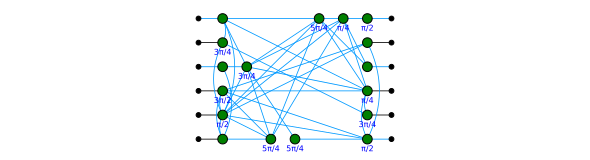

In [13]:
g.normalize() # Reposition nodes horizontally to look nicer
zx.draw_matplotlib(g)

The blue lines represent wires that have a Hadamard gate on them.

### Exercise

Let's see a bit more detail on what goes into rewriting this circuit. The objective of the exercise is that, starting from the original circuit, you derive the reduced graph shown above. To make things easier and to display the derivation steps nicely, we've implemented the class `Steps` that will be managing PyZX's backend so you don't have to worry about it.

In [ ]:
from ipywidgets import widgets
from IPython.display import display, Markdown

import pyzx.rules as r

class Steps:
    def __init__(self,g):
        self.current  = g.copy()
        self.stepList = [zx.draw_matplotlib(self.current,h_edge_draw='box')]
        self.stepNames = ['start']
    
    def applyXTimes(self,name,match,rule,x):
        for i in range(x):
            self.applyOnce(name,match,rule)
            
    def applyOnce(self,name,match,rule):
        m = match(self.current)
        if len(m) > 0:
            zx.rules.apply_rule(self.current,rule,[m[0]])
            self.stepList.append(zx.draw_matplotlib(self.current,h_edge_draw='box'))
            self.stepNames.append(name)
    
    def to_gh(self):
        zx.to_gh(self.current)
        self.stepList.append(zx.draw_matplotlib(self.current,h_edge_draw='box'))
        self.stepNames.append('to_gh')
    
    def plotter(self,rewrite):
        display(self.stepList[rewrite])
        display(Markdown("**Rewrite step**: " + self.stepNames[rewrite]))
    
    def drawSteps(self):
        self.current.normalize()
        self.stepList.append(zx.draw_matplotlib(self.current))
        self.stepNames.append('rearrange')
        w = widgets.interactive(self.plotter, rewrite=(0,len(self.stepList)-1))
        slider = w.children[0]
        slider.value = 0
        return w

Your task is to use the function `applyXTimes` to apply ZX rules on the diagram until it reaches the reduced form given above. You will need to apply some combination of the rules listed below, possibly interleaving them:
- removal of identities (phases with angle 0) `s.applyXTimes('id', r.match_ids, r.remove_ids, x)`,
- spider contraction `s.applyXTimes('spider', r.match_spider, r.spider, x)`;
- local complementation `s.applyXTimes('lcomp', r.match_lcomp, r.lcomp, x)`;
- pivoting `s.applyXTimes('pivot', r.match_pivot, r.pivot, x)`.

Argument `x` indicates how many consecutive times the same rule should be applied. Write your code in the snippet below. The last line on the snippet must be `display(s.drawSteps())`, which will display the derivation you've come up with. A sliding bar should allow you to scroll over the different steps of your derivation (this requires that you have succesfully enabled ipywidgets).

**Note**: The final diagram you get might not be exactly the same as the reduced graph shown above (it depends on the order you apply the rules). Nevertheless, it is certain that their corresponding matrices will be equivalent: the rules of the ZX-calculus preserve equality of the 'matrix semantics'.

In [ ]:
s = Steps(circ) #Create an instance of the Steps class we just defined


### APPLY THE FIRST ROUND OF RULES HERE ###
s.applyXTimes('spider', r.match_spider, r.spider, 2)




s.to_gh() #Convert all X-phases (red nodes) into Z-phases surrounded by H-boxes. This is a necessary step.

### APPLY THE SECOND ROUND OF RULES HERE ###
s.applyXTimes('spider', r.match_spider, r.spider, 3)




display(s.drawSteps())

<details>
<summary> Answer (Click me!)</summary>

This is just one way that works, there are many equivalent ones:
    
```python
s = Steps(circ) #Create an instance of the Steps class we just defined

### APPLY THE FIRST ROUND OF RULES HERE ###
s.applyXTimes('spider', r.match_spider, r.spider, 20)

s.to_gh() #Convert all X-phases (red nodes) into Z-phases surrounded by H-boxes. This is a necessary step.

### APPLY THE SECOND ROUND OF RULES HERE ###
s.applyXTimes('spider', r.match_spider, r.spider, 3)
s.applyXTimes('pivot', r.match_pivot, r.pivot, 15)
s.applyXTimes('lcomp', r.match_lcomp, r.lcomp, 15)
s.applyXTimes('pivot', r.match_pivot, r.pivot, 15)

display(s.drawSteps())
```
</details>

### Recovering the circuit

Even though this graph is a lot compacter than the one we started out with, it no longer looks like a circuit. To fix this we need to be clever.

In [6]:
circ2 = zx.extract_circuit(g.copy())
zx.draw(circ2)

Here, we have used function `zx.extract.clifford_extract(circ2,1,2)` to ask PyZX to find a way to implement our compact diagram using quantum gates. This diagram is found using, almost exclusively, the spider rule and the colour change rule. The last two arguments of the function identify the segment of the diagram we want to extract as a circuit; in this case, the whole diagram (from the first column of the green phases to the second one).

To verify that this circuit is still equal to the original circuit, we can transform them into numpy tensors and compare these tensors for equality:

In [ ]:
t1 = circ.to_tensor()
t2 = circ2.to_tensor()
# This checks whether t1 and t2 are equal up to some number: t1 == z*t2 for some complex number z
zx.compare_tensors(t1,t2,preserve_scalar=False) 

Note that `circ2` is a variable of type `zx.Circuit`, and we can list the gates with:

In [ ]:
print(circ2.gates)

This printed a description of the sequence of gates from left to right. We can also represent the circuit in one of several quantum circuit description languages, such as Quipper:

In [ ]:
print(circ2.to_quipper())

## Approximately universal circuits

Now lets try the same thing with a more complicated Clifford+T circuit (i.e. it may include $\pi/4$ phases).

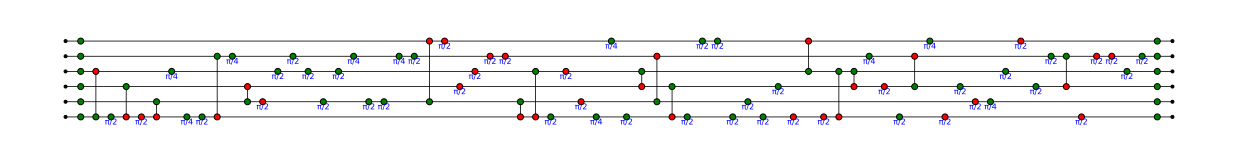

In [7]:
qubit_amount = 6
depth = 70
random.seed(1338)
circ = zx.generate.cliffordT(qubit_amount, depth,p_t=0.2)
zx.draw_matplotlib(circ,figsize=(17,2),h_edge_draw='box')

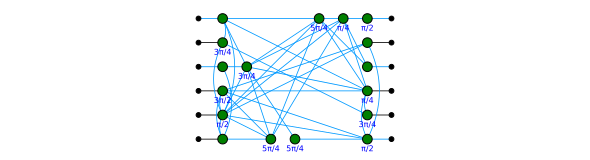

In [12]:
g = circ.copy()
zx.clifford_simp(g, quiet=True)
g.normalize()
zx.draw_matplotlib(g)

Once we get the reduced diagram, we ask PyZX to extract the circuit:

In [9]:
g2 = g.copy()
c = zx.extract.extract_circuit(g2)
print(c.stats())

Circuit  on 6 qubits with 62 gates.
        8 is the T-count
        54 Cliffords among which 
        28 2-qubit gates (2 CNOT, 26 other) and
        22 Hadamard gates.


We can convert this back into a PyZX-graph:

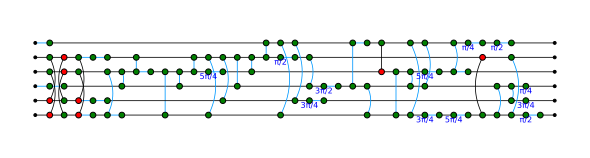

In [11]:
zx.draw_matplotlib(c.to_graph())

And verify that it is still equal to the original graph:

In [14]:
zx.compare_tensors(c.to_tensor(), circ.to_tensor(),preserve_scalar=False)

True

Finally, lets represent this circuit in the QASM circuit description language:

In [15]:
print(c.to_basic_gates().to_qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[6];
cx q[2], q[5];
cx q[5], q[2];
cx q[2], q[5];
cx q[1], q[4];
cx q[4], q[1];
cx q[1], q[4];
h q[5];
h q[4];
h q[3];
h q[1];
h q[1];
h q[3];
cz q[2], q[5];
cz q[2], q[3];
cz q[1], q[2];
h q[2];
h q[5];
cz q[2], q[5];
cz q[2], q[3];
cz q[1], q[2];
rz(1.25*pi) q[2];
h q[0];
h q[2];
h q[4];
cz q[1], q[5];
cz q[1], q[4];
cz q[1], q[3];
cz q[1], q[2];
cz q[0], q[1];
rz(0.5*pi) q[1];
h q[1];
cz q[1], q[3];
rz(1.5*pi) q[3];
h q[3];
cz q[0], q[5];
cz q[0], q[4];
cz q[0], q[3];
h q[0];
cx q[0], q[2];
cz q[3], q[5];
cz q[2], q[5];
cz q[0], q[5];
rz(0.75*pi) q[5];
h q[5];
rz(1.25*pi) q[5];
h q[5];
cx q[5], q[1];
cz q[2], q[3];
rz(1.25*pi) q[2];
h q[2];
cz q[0], q[3];
cz q[0], q[2];
rz(0.75*pi) q[4];
rz(0.25*pi) q[0];
h q[4];
h q[0];
cz q[3], q[5];
cz q[3], q[4];
cz q[1], q[5];
rz(0.5*pi) q[5];
h q[5];
rz(0.75*pi) q[4];
rz(0.25*pi) q[3];
h q[2];
rz(0.5*pi) q[0];
h q[0];



## Implementing a basic rewrite

Now, let's take a look at implementing ZX-calculus rewrites within PyZX. For the sake of simplicity, we'll have a look at one of the simplest possible rules, which is used to remove red and green identities from a diagram:
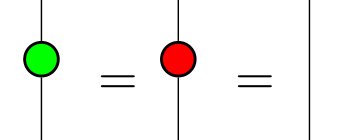

Let's first import a test diagram to apply this rule to:

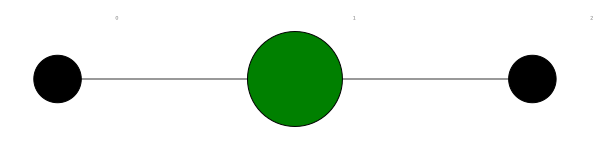

In [17]:
identity_lhs = zx.Graph()

# Adds vertices to the diagram with spacing
identity_lhs.add_vertex()
identity_lhs.add_vertex(row=0)
identity_lhs.add_vertex(row=1)

# Sets the type of the vertices
identity_lhs.set_inputs({0})
identity_lhs.set_outputs({2})
identity_lhs.set_type(1, zx.VertexType.Z)

# Adds edges to the diagram
identity_lhs.add_edges({(0,1), (1,2)})

zx.draw_matplotlib(identity_lhs, labels=True)

In PyZX, we would apply the "identity" rule to a diagram `g` by calling:

In [ ]:
g = identity_lhs.copy() # makes a copy of the diagram so we can reuse the original later
zx.simplify.simp(g, "id", zx.rules.match_ids, zx.rules.remove_ids) # applies the rewrite
zx.draw(g, labels=True)

Let's take a look at what the function `zx.rules.match_ids` actually does.

In [ ]:
zx.rules.match_ids(identity_lhs)

Let's parse this result: `match_ids` returns a list of quadruples, each of which takes the form of a sequence of 3 vertices followed by a `zx.EdgeType` integer. The three vertices correspond to a green or red spider matching the LHS of the "identity" rule, i.e. the central vertex 1 of our diagram `identity_lhs`. The two other vertices in the tuple are the neighbours of this central vertex.

The last element of the tuple is a little trickier. In PyZX, there are 2 types of edges: plain edges, and edges that carry a Hadamard box. If the central vertex is connected to its neighbours with edges that carry a Hadamard box, this needs to be carried forward when we do the rewrite. Luckily, `match_ids` also computes what the final edge type should be in the diagram, and returns this value as the corresponding integer, matching either  `zx.EdgeType.SIMPLE` or `zx.EdgeType.HADAMARD`.

`remove_ids` should communicate this information to `zx.simplify.simp` as its return. Let see what it actually does:

In [ ]:
g = identity_lhs.copy()
zx.rules.remove_ids(g, zx.rules.match_ids(identity_lhs))

`remove_ids` returns another quadruple `(edges_to_edit, vertices_to_remove, vertices_to_add, isolated_vertices)` consisting in:
* `edges_to_add`: a dictionary of edges to add to `g`; the keys of the dictionary are pairs `(x,y)` corresponding to the edges to add, and the value associated to an edge (=key) is a pair `[a,b]` where `a` is the number of edges of type `zx.EdgeType.SIMPLE` and `b` is the number of edges of type `zx.EdgeType.HADAMARD`.
* `vertices_to_remove`: a list of vertices to remove from `g`;
* `edges_to_remove`: a list of vertices to add to `g`;
* `isolated_vertices`: a boolean which says whether the rule will result in isolated vertices in the graph.

### Exercise

Can you now implement your own version of `remove_ids`? It should take two arguments: the diagram `g` to apply the rewrite rule to, and the result of calling `match_ids` on `g`. For each match, we want to apply the corresponding rewrite, by: 
1. deleting the central vertex;
2. connecting the two neighbours by an edge of the correct type.

Deleting the central vertex removes all connected edges, so we do not need to take care of edge removal when applying the identity rule. Since the identity rule should also never result in isolated vertices, we can safely ignore the two last return values:

In [ ]:
def my_remove_ids(g, matches):
    edges_to_edit = dict()
    vertices_to_remove = []
    
    for v, neighbor0, neighbor1, edge_type in matches:
        # Your code here:
        ...
    
    return (edges_to_edit, vertices_to_remove, [], False)

<details>
<summary> Answer (Click me!)</summary>
    
```python
def my_remove_ids(g, matches):
    edges_to_add = dict()
    vertices_to_remove = []
    
    for v, neighbor0, neighbor1, edge_type in matches:
        vertices_to_remove.append(v)
        e = g.edge(neighbor0, neighbor1)
        if not e in edges_to_add:
            edges_to_add[e] = [0,0]
        if edge_type == zx.EdgeType.SIMPLE: 
            edges_to_add[e][0] += 1
        else: edges_to_add[e][1] += 1
            
    return (edges_to_add, vertices_to_remove, [], False)
```
</details>

Try it out:

In [ ]:
g = identity_lhs.copy()
zx.simplify.simp(g, "id", zx.rules.match_ids, my_remove_ids)
zx.draw(g)

## Bonus: Optimising T-count

The Clifford+T gateset is universal for quantum computation: every circuit can be built using gates from it. Among its gates, the most expensive ones are the CNOT gate (the only two-qubit gate in the set) and the T gate, which corresponds to a Z-phase of angle $\pi/4$. A stardard objective in quantum circuit optimisation is the reduction of the T-count: the number of T gates in the circuit. This section provides an introduction to *phase teleportation*, a procedure for T-count reduction based on the ZX-calculus. This procedure was first proposed in a scientific paper from 2019: https://arxiv.org/pdf/1903.10477.pdf.

As it happened with the previous section, we first need to take a moment to define the ZX-diagrams we are interested in and the rules that can be applied to them. We shall explore these using Quantomatic. **Follow the last section of the lab session's PDF**, then continue from here.

### Example

Here we apply phase teleportation to reduce the T-count of a particular quantum circuit. The circuit is a 3-control Toffoli, which is a 4-qubit gate where the first three wires act as control and the fourth has an X gate applied to it if and only if the controls are all simultaneously in state $\lvert 1 \rangle$. The circuit that implements such a gate using the Clifford+T gateset is shown below as a ZX-diagram. The wire at the bottom carries and auxiliary 'helper' qubit and should be initialised to $\lvert 0 \rangle$.

In [ ]:
circ = zx.circuit.Circuit.load(".assets/CCCNOT").to_basic_gates()

print("The original circuit:")
display(zx.draw_matplotlib(circ,h_edge_draw='box'))
g = circ.to_graph()

As you can see, there are plenty of $T$ gates (and $T^\dagger$, phases with $-\pi/4$ angle). The code below executes the different stages of the phase teleportation procedure. We use an updated version of our `Steps` class to display the circuit after each stage.

In [ ]:
class BonusSteps(Steps):
    
    def apply_clifford_simp(self):
        zx.simplify.clifford_simp(self.current)
        self.stepList.append(zx.draw(self.current))
        self.stepNames.append('clifford')
        
    def apply_pivot_gadget_simp(self):
        zx.simplify.pivot_gadget_simp(self.current)
        self.stepList.append(zx.draw(self.current))
        self.stepNames.append('pivot gadget')
        
    def apply_gadget_simp(self):
        zx.simplify.gadget_simp(self.current)
        self.stepList.append(zx.draw(self.current))
        self.stepNames.append('gadget fusion')

bs = BonusSteps(g)

print("List of rules applied during the derivation:\n")
bs.apply_clifford_simp()
bs.apply_pivot_gadget_simp()
bs.apply_gadget_simp()
bs.apply_clifford_simp()

display(bs.drawSteps())

In order to apply phase teleportation we first need to identify the phase gadgets in the circuit and bring them as close together as possible. To do so, we use Clifford circuit simplification (described in the first section of this sheet) and a special version of pivoting. Then, we attempt to apply the `gadget_fusion` rule we introduced in the last Quantomatic exercise. This will reduce the number of Z-phases of angle $\pi/4$ (and $-\pi/4$), i.e. it will decrease the number of T gates (and their inverse) in the circuit. Normally, after fusing gadgets we would again do a round of Clifford simplification and gadgetization (using pivoting) and try to fuse gadgets again, repeating this cycle until it's not possible to fuse any more gadgets.

Once all possible gadget fusions are done, we backtrack all the rewriting process, but with the angles on some of the gadgets changed. In the end, we recover the circuit we started with, obtaining the *exact* same structure but some of the T gates having disappeared, being converted to $\pi/2$ or $0$ rotations thanks to the fusion of their corresponding phase gadgets.

In [ ]:
print("The circuit after phase teleportation:")
circ2 = zx.simplify.teleport_reduce(g)
display(zx.draw(circ2))

Looking at the initial and final circuits, it seems like we found a way to teleport $\pi/4$ phases from their original place to a distant point on the circuit, cancelling them with the T gate there. Even in such a small example, the T-count reduction is significant:

In [ ]:
print("Original T-count:\t", zx.tcount(circ))
print("Final T-count:\t\t", zx.tcount(circ2))